In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pickle

In [2]:
df =  pd.read_csv('../dataset/booking_train.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
df['type_of_meal']=df['type_of_meal'].str.lower().str.replace(' ', '_')
df['room_type']=df['room_type'].str.lower().str.replace(' ', '_')
df['market_segment_type']=df['market_segment_type'].str.lower().str.replace(' ', '_')
df = df[~df["date_of_reservation"].str.contains("-")]
df['month_of_reservation'] = pd.to_datetime(df['date_of_reservation'],format='%m/%d/%Y').dt.strftime('%b') 
df['booking_status'] = (df.booking_status == 'Canceled').astype(int)

In [141]:
#Perform the train/validation/test split with Scikit-Learn
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df,test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train,test_size=0.25, random_state=1)
df_full_train  = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
y_full_train = df_full_train['booking_status'].values
y_train = df_train['booking_status'].values
y_val = df_val['booking_status'].values
y_test = df_test['booking_status'].values
del df_train['booking_status']
del df_val['booking_status']
del df_test['booking_status']


In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [142]:
numerical = ['number_of_adults','number_of_children','number_of_weekend_nights','number_of_week_nights','lead_time','p-c','p-not-c','average_price','special_requests']
categorical = ['type_of_meal','room_type','market_segment_type','car_parking_space','repeated','month_of_reservation']

full_train_dict = df_full_train[categorical + numerical].to_dict(orient='records')
train_dict = df_train[categorical + numerical].to_dict(orient='records')
val_dict = df_val[categorical + numerical].to_dict(orient='records')
test_dict = df_test[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)
X_test = dv.transform(test_dict)
X_full_train = dv.transform(full_train_dict)

features = list(dv.get_feature_names_out())
features

['average_price',
 'car_parking_space',
 'lead_time',
 'market_segment_type=aviation',
 'market_segment_type=complementary',
 'market_segment_type=corporate',
 'market_segment_type=offline',
 'market_segment_type=online',
 'month_of_reservation=Apr',
 'month_of_reservation=Aug',
 'month_of_reservation=Dec',
 'month_of_reservation=Feb',
 'month_of_reservation=Jan',
 'month_of_reservation=Jul',
 'month_of_reservation=Jun',
 'month_of_reservation=Mar',
 'month_of_reservation=May',
 'month_of_reservation=Nov',
 'month_of_reservation=Oct',
 'month_of_reservation=Sep',
 'number_of_adults',
 'number_of_children',
 'number_of_week_nights',
 'number_of_weekend_nights',
 'p-c',
 'p-not-c',
 'repeated',
 'room_type=room_type_1',
 'room_type=room_type_2',
 'room_type=room_type_3',
 'room_type=room_type_4',
 'room_type=room_type_5',
 'room_type=room_type_6',
 'room_type=room_type_7',
 'special_requests',
 'type_of_meal=meal_plan_1',
 'type_of_meal=meal_plan_2',
 'type_of_meal=meal_plan_3',
 'type_o

In [10]:
import xgboost as xgb

In [140]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

In [11]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1
}

In [12]:
model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [13]:
y_pred = model.predict(dval)
y_pred

array([0.30798873, 0.73791575, 0.1452187 , ..., 0.15863523, 0.30303952,
       0.19408129], dtype=float32)

In [14]:
roc_auc_score(y_val, y_pred)

0.9357873666416862

In [15]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [16]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

In [26]:
model = xgb.train(xgb_params, dtrain,
                  num_boost_round=200,
                  evals=watchlist, verbose_eval=10)

[0]	train-auc:0.94227	val-auc:0.92609
[10]	train-auc:0.95488	val-auc:0.93661
[20]	train-auc:0.96104	val-auc:0.94068
[30]	train-auc:0.96459	val-auc:0.94368
[40]	train-auc:0.96690	val-auc:0.94557
[50]	train-auc:0.97039	val-auc:0.94752
[60]	train-auc:0.97178	val-auc:0.94837
[70]	train-auc:0.97402	val-auc:0.94916
[80]	train-auc:0.97575	val-auc:0.94991
[90]	train-auc:0.97874	val-auc:0.95138
[100]	train-auc:0.98087	val-auc:0.95180
[110]	train-auc:0.98271	val-auc:0.95256
[120]	train-auc:0.98444	val-auc:0.95279
[130]	train-auc:0.98561	val-auc:0.95287
[140]	train-auc:0.98695	val-auc:0.95312
[150]	train-auc:0.98830	val-auc:0.95358
[160]	train-auc:0.98898	val-auc:0.95362
[170]	train-auc:0.98947	val-auc:0.95366
[180]	train-auc:0.99020	val-auc:0.95350
[190]	train-auc:0.99094	val-auc:0.95376
[199]	train-auc:0.99135	val-auc:0.95397


In [21]:
def parse_xgb_output(output):
    tree = []
    aucs_train = []
    aucs_val = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        tree.append(it)
        aucs_train.append(train)
        aucs_val.append(val)

    return tree, aucs_train, aucs_val

In [27]:
%%capture output
model = xgb.train(xgb_params, dtrain,
                  num_boost_round=200,
                  evals=watchlist, verbose_eval=10)

In [28]:
tree, train_auc, val_auc = parse_xgb_output(output)

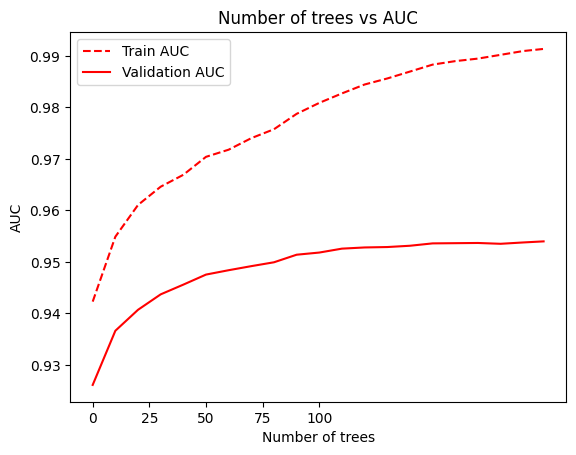

In [30]:
plt.plot(tree, train_auc, color='red', linestyle='dashed', label='Train AUC')
plt.plot(tree, val_auc, color='red', linestyle='solid', label='Validation AUC')
plt.xticks(range(0, 101, 25))

plt.legend()

plt.title('Number of trees vs AUC')
plt.xlabel('Number of trees')
plt.ylabel('AUC')

plt.show()

In [ ]:
# Trying for eta [0.1, -0.3, 0.05, 0.005, 0.01, 0.001]

In [62]:
%%capture output
#ETA is 0.1
xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500,
                  evals=watchlist, verbose_eval=10)



In [63]:
tree, train_auc_eta_01, val_auc_eta_01 = parse_xgb_output(output)
print(max(val_auc_eta_01))
print(max(zip(val_auc_eta_01, tree)))

0.95468
(0.95468, 380)


In [64]:
%%capture output
#ETA is 0.01
xgb_params = {
    'eta': 0.01,
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500,
                  evals=watchlist, verbose_eval=10)



In [65]:
tree, train_auc_eta_001, val_auc_eta_001 = parse_xgb_output(output)
print(max(val_auc_eta_001))
print(max(zip(val_auc_eta_001, tree)))

0.94795
(0.94795, 499)


In [66]:
%%capture output
#ETA is 0.05
xgb_params = {
    'eta': 0.05,
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500,
                  evals=watchlist, verbose_eval=10)

In [67]:
tree, train_auc_eta_005, val_auc_eta_005 = parse_xgb_output(output)
print(max(val_auc_eta_005))
print(max(zip(val_auc_eta_005, tree)))

0.95468
(0.95468, 460)


In [69]:
%%capture output
#ETA is 0.5
xgb_params = {
    'eta': 0.5,
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500,
                  evals=watchlist, verbose_eval=10)

In [70]:
tree, train_auc_eta_05, val_auc_eta_05 = parse_xgb_output(output)
print(max(val_auc_eta_05))
print(max(zip(val_auc_eta_05, tree)))

0.95198
(0.95198, 70)


In [72]:
%%capture output
#ETA is 0.3
xgb_params = {
    'eta': 0.3,
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500,
                  evals=watchlist, verbose_eval=10)

In [74]:
tree, train_auc_eta_03, val_auc_eta_03 = parse_xgb_output(output)
print(max(val_auc_eta_03))
print(max(zip(val_auc_eta_03, tree)))

0.95355
(0.95355, 90)


In [75]:
%%capture output
#ETA is 0.7
xgb_params = {
    'eta': 0.7,
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500,
                  evals=watchlist, verbose_eval=10)

In [76]:
tree, train_auc_eta_07, val_auc_eta_07 = parse_xgb_output(output)
print(max(val_auc_eta_07))
print(max(zip(val_auc_eta_07, tree)))

0.94985
(0.94985, 30)


In [77]:
%%capture output
#ETA is 0.01
xgb_params = {
    'eta': 0.01,
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500,
                  evals=watchlist, verbose_eval=10)

In [78]:
tree, train_auc_eta_001, val_auc_eta_001 = parse_xgb_output(output)
print(max(val_auc_eta_001))
print(max(zip(val_auc_eta_001, tree)))

0.94795
(0.94795, 499)


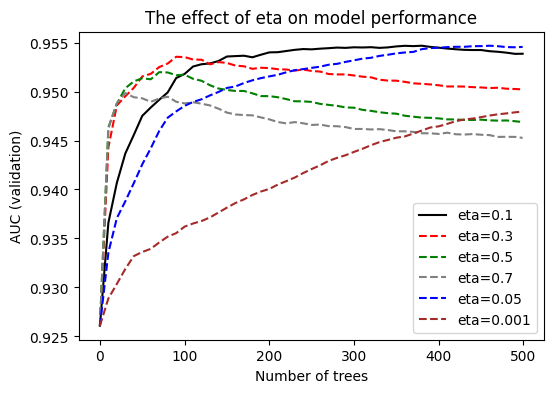

In [79]:
plt.plot(tree, val_auc_eta_01, color='black', linestyle='solid', label='eta=0.1')
plt.plot(tree, val_auc_eta_03, color='red', linestyle='dashed', label='eta=0.3')
plt.plot(tree, val_auc_eta_05, color='green', linestyle='dashed', label='eta=0.5')
plt.plot(tree, val_auc_eta_07, color='grey', linestyle='dashed', label='eta=0.7')
plt.plot(tree, val_auc_eta_005, color='blue', linestyle='dashed', label='eta=0.05')
plt.plot(tree, val_auc_eta_001, color='brown', linestyle='dashed', label='eta=0.001')

plt.xticks(range(0, 501, 100))

plt.legend()

plt.title('The effect of eta on model performance')
plt.xlabel('Number of trees')
plt.ylabel('AUC (validation)')

plt.show()

In [ ]:
#eta 0.1 looks good from 150 trees

In [ ]:
#Fine tuning max depth for [3, 5, 10, 20, 30]

In [80]:
%%capture output
#max depth 3
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500,
                  evals=watchlist, verbose_eval=10)

In [81]:
tree, train_auc_max_depth_3, val_auc_max_depth_3 = parse_xgb_output(output)
print(max(val_auc_max_depth_3))
print(max(zip(val_auc_max_depth_3, tree)))

0.9373
(0.9373, 499)


In [82]:
%%capture output
#max depth 5
xgb_params = {
    'eta': 0.1,
    'max_depth': 5,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500,
                  evals=watchlist, verbose_eval=10)

In [83]:
tree, train_auc_max_depth_5, val_auc_max_depth_5 = parse_xgb_output(output)
print(max(val_auc_max_depth_5))
print(max(zip(val_auc_max_depth_5, tree)))

0.95101
(0.95101, 499)


In [86]:
%%capture output
#max depth 10
xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500,
                  evals=watchlist, verbose_eval=10)

In [87]:
tree, train_auc_max_depth_10, val_auc_max_depth_10 = parse_xgb_output(output)
print(max(val_auc_max_depth_10))
print(max(zip(val_auc_max_depth_10, tree)))

0.95468
(0.95468, 380)


In [88]:
%%capture output
#max depth 20
xgb_params = {
    'eta': 0.1,
    'max_depth': 20,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500,
                  evals=watchlist, verbose_eval=10)

In [89]:
tree, train_auc_max_depth_20, val_auc_max_depth_20 = parse_xgb_output(output)
print(max(val_auc_max_depth_20))
print(max(zip(val_auc_max_depth_20, tree)))

0.95403
(0.95403, 100)


In [90]:
%%capture output
#max depth 30
xgb_params = {
    'eta': 0.1,
    'max_depth': 30,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500,
                  evals=watchlist, verbose_eval=10)

In [91]:
tree, train_auc_max_depth_30, val_auc_max_depth_30 = parse_xgb_output(output)
print(max(val_auc_max_depth_30))
print(max(zip(val_auc_max_depth_30, tree)))

0.95328
(0.95328, 120)


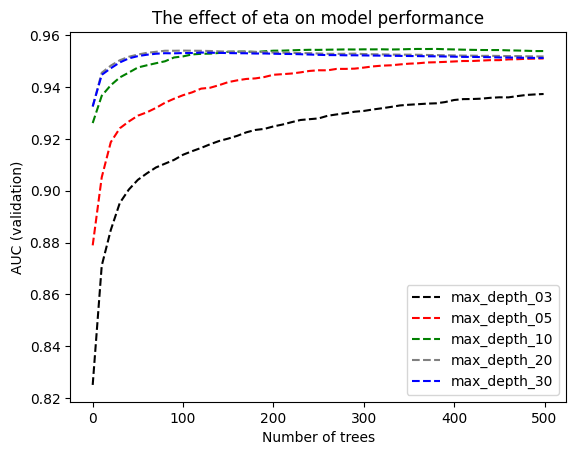

In [96]:
plt.plot(tree, val_auc_max_depth_3, color='black', linestyle='dashed', label='max_depth_03')
plt.plot(tree, val_auc_max_depth_5, color='red', linestyle='dashed', label='max_depth_05')
plt.plot(tree, val_auc_max_depth_10, color='green', linestyle='dashed', label='max_depth_10')
plt.plot(tree, val_auc_max_depth_20, color='grey', linestyle='dashed', label='max_depth_20')
plt.plot(tree, val_auc_max_depth_30, color='blue', linestyle='dashed', label='max_depth_30')


plt.xticks(range(0, 501, 100))

plt.legend()

plt.title('The effect of eta on model performance')
plt.xlabel('Number of trees')
plt.ylabel('AUC (validation)')

plt.show()



In [97]:
#max depth 10 and 20 seems simalar.. picking 10 at 100 tree

In [ ]:
#Tuning min child weight [2, 5, 10, 15, 20]

In [104]:
%%capture output
#min child weight 2
xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 2,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500,
                  evals=watchlist, verbose_eval=10)

In [105]:
tree, train_auc_min_child_weight_2, val_auc_min_child_weight_2 = parse_xgb_output(output)
print(max(val_auc_min_child_weight_2))
print(max(zip(val_auc_min_child_weight_2, tree)))

0.95492
(0.95492, 290)


In [106]:
%%capture output
#min child weight 5
xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 5,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500,
                  evals=watchlist, verbose_eval=10)

In [107]:
tree, train_auc_min_child_weight_5, val_auc_min_child_weight_5 = parse_xgb_output(output)
print(max(val_auc_min_child_weight_5))
print(max(zip(val_auc_min_child_weight_5, tree)))

0.95303
(0.95303, 390)


In [109]:
%%capture output
#min child weight 10
xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 10,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500,
                  evals=watchlist, verbose_eval=10)

In [110]:
tree, train_auc_min_child_weight_10, val_auc_min_child_weight_10 = parse_xgb_output(output)
print(max(val_auc_min_child_weight_10))
print(max(zip(val_auc_min_child_weight_10, tree)))

0.95154
(0.95154, 450)


In [111]:
%%capture output
#min child weight 15
xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 15,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500,
                  evals=watchlist, verbose_eval=10)

In [112]:
tree, train_auc_min_child_weight_15, val_auc_min_child_weight_15 = parse_xgb_output(output)
print(max(val_auc_min_child_weight_15))
print(max(zip(val_auc_min_child_weight_15, tree)))

0.94964
(0.94964, 490)


In [113]:
%%capture output
#min child weight 20
xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 20,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500,
                  evals=watchlist, verbose_eval=10)

In [114]:
tree, train_auc_min_child_weight_20, val_auc_min_child_weight_20 = parse_xgb_output(output)
print(max(val_auc_min_child_weight_20))
print(max(zip(val_auc_min_child_weight_20, tree)))

0.94806
(0.94806, 499)


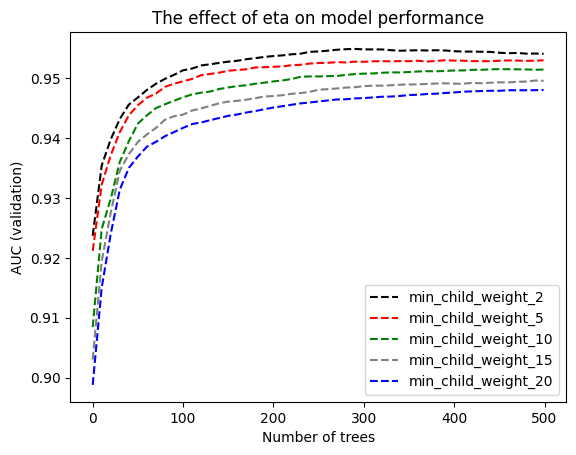

In [115]:
plt.plot(tree, val_auc_min_child_weight_2, color='black', linestyle='dashed', label='min_child_weight_2')
plt.plot(tree, val_auc_min_child_weight_5, color='red', linestyle='dashed', label='min_child_weight_5')
plt.plot(tree, val_auc_min_child_weight_10, color='green', linestyle='dashed', label='min_child_weight_10')
plt.plot(tree, val_auc_min_child_weight_15, color='grey', linestyle='dashed', label='min_child_weight_15')
plt.plot(tree, val_auc_min_child_weight_20, color='blue', linestyle='dashed', label='min_child_weight_20')


plt.xticks(range(0, 501, 100))

plt.legend()

plt.title('The effect of eta on model performance')
plt.xlabel('Number of trees')
plt.ylabel('AUC (validation)')

plt.show()

In [163]:
%%capture output
#subsample = 0.5
xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 2,
    'subsample': 0.5,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500,
                  evals=watchlist, verbose_eval=10)

In [164]:
tree, train_auc_subsample_05, val_auc_sub_sample_05 = parse_xgb_output(output)
print(max(val_auc_sub_sample_05))
print(max(zip(val_auc_sub_sample_05, tree)))

0.9521
(0.9521, 150)


In [165]:
%%capture output
#subsample = 0.7
xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 2,
    'subsample': 0.7,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500,
                  evals=watchlist, verbose_eval=10)

In [166]:
tree, train_auc_subsample_07, val_auc_sub_sample_07 = parse_xgb_output(output)
print(max(val_auc_sub_sample_07))
print(max(zip(val_auc_sub_sample_07, tree)))

0.95342
(0.95342, 250)


In [167]:
%%capture output
#subsample = 1
xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 2,
    'subsample': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500,
                  evals=watchlist, verbose_eval=10)

In [168]:
tree, train_auc_subsample_1, val_auc_sub_sample_1 = parse_xgb_output(output)
print(max(val_auc_sub_sample_1))
print(max(zip(val_auc_sub_sample_1, tree)))

0.95492
(0.95492, 290)


In [ ]:
#subsample value = 1 which is default looks better than others

In [ ]:
#'colsample_bytree': 0.3, 0.5

In [169]:
%%capture output
#colsample_bytree = 0.5
xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 2,
    'colsample_bytree': 0.5,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500,
                  evals=watchlist, verbose_eval=10)

In [170]:
tree, train_auc_colsample_05, val_auc_col_sample_05 = parse_xgb_output(output)
print(max(val_auc_col_sample_05))
print(max(zip(val_auc_col_sample_05, tree)))

0.95492
(0.95492, 410)


In [171]:
%%capture output
#colsample_bytree = 0.3
xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 2,
    'colsample_bytree': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500,
                  evals=watchlist, verbose_eval=10)

In [172]:
tree, train_auc_colsample_03, val_auc_col_sample_03 = parse_xgb_output(output)
print(max(val_auc_col_sample_03))
print(max(zip(val_auc_col_sample_03, tree)))

0.95323
(0.95323, 490)


In [ ]:
#colsample_bytree = 1 deafult seems better than others values/ Going with default.

In [116]:
#min_child_weight = 2 seems better than others.

#final values
eta = 0.1 
min_child_weight = 2
max_depth = 10

In [118]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 2,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500,
                  evals=watchlist, verbose_eval=10)

In [119]:
print(output)

[0]	train-auc:0.93959	val-auc:0.92371
[10]	train-auc:0.95250	val-auc:0.93546
[20]	train-auc:0.95857	val-auc:0.93982
[30]	train-auc:0.96171	val-auc:0.94322
[40]	train-auc:0.96498	val-auc:0.94562
[50]	train-auc:0.96678	val-auc:0.94681
[60]	train-auc:0.96881	val-auc:0.94807
[70]	train-auc:0.97146	val-auc:0.94910
[80]	train-auc:0.97384	val-auc:0.94992
[90]	train-auc:0.97583	val-auc:0.95059
[100]	train-auc:0.97748	val-auc:0.95135
[110]	train-auc:0.97885	val-auc:0.95164
[120]	train-auc:0.98033	val-auc:0.95216
[130]	train-auc:0.98175	val-auc:0.95235
[140]	train-auc:0.98305	val-auc:0.95259
[150]	train-auc:0.98414	val-auc:0.95279
[160]	train-auc:0.98526	val-auc:0.95294
[170]	train-auc:0.98622	val-auc:0.95320
[180]	train-auc:0.98677	val-auc:0.95338
[190]	train-auc:0.98753	val-auc:0.95358
[200]	train-auc:0.98840	val-auc:0.95373
[210]	train-auc:0.98906	val-auc:0.95384
[220]	train-auc:0.98962	val-auc:0.95402
[230]	train-auc:0.99050	val-auc:0.95412
[240]	train-auc:0.99122	val-auc:0.95443
[250]	train

In [122]:
tree, _, val_auc = parse_xgb_output(output)
print(max(val_auc))
max(zip(val_auc, tree))

0.95492


(0.95492, 290)

In [ ]:
#final model

xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 2,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=290,
                  evals=watchlist, verbose_eval=10)

In [124]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.9541049695882697

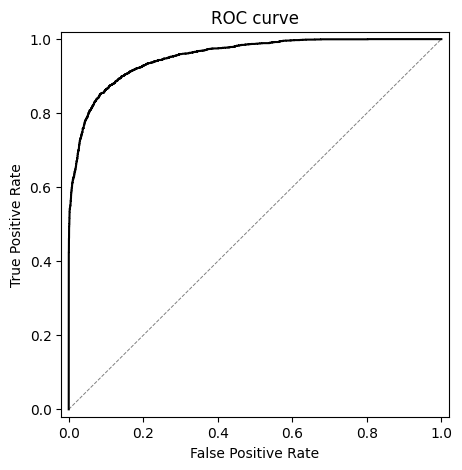

In [128]:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_val, y_pred)
plt.plot(fpr, tpr, color='black')


plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

plt.show()

In [129]:
#finat auc score for xgb => 0.9541049695882697

In [147]:
#min_sample_size looks simimlar at estimator=30, max_depth 20, min_samples=5
#final model

dtrain_full = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)


xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 2,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain_full,
                  num_boost_round=290)
model

In [148]:
y_pred = model.predict(dtest)

In [152]:
print(roc_auc_score(y_test, y_pred))


0.9524001761121099


In [156]:
scores = model.get_score(importance_type='gain')
scores = sorted(scores.items(), key=lambda x: x[1])
list(reversed(scores))

[('market_segment_type=online', 47.39923858642578),
 ('special_requests', 15.915420532226562),
 ('car_parking_space', 12.751692771911621),
 ('month_of_reservation=Dec', 8.930776596069336),
 ('month_of_reservation=Jan', 6.965875148773193),
 ('lead_time', 6.769908428192139),
 ('market_segment_type=offline', 5.430438995361328),
 ('number_of_adults', 5.377709865570068),
 ('repeated', 4.527021884918213),
 ('month_of_reservation=Apr', 4.314088821411133),
 ('month_of_reservation=Jun', 4.152012348175049),
 ('month_of_reservation=Feb', 4.074530601501465),
 ('average_price', 3.624248743057251),
 ('month_of_reservation=Nov', 3.401684284210205),
 ('market_segment_type=complementary', 3.2203187942504883),
 ('month_of_reservation=Oct', 3.028904914855957),
 ('month_of_reservation=May', 2.777859926223755),
 ('number_of_weekend_nights', 2.768362522125244),
 ('month_of_reservation=Sep', 2.665900945663452),
 ('type_of_meal=meal_plan_1', 2.5012409687042236),
 ('month_of_reservation=Mar', 2.430618286132812

In [157]:
scores = model.get_score(importance_type='weight')
scores = sorted(scores.items(), key=lambda x: x[1])
list(reversed(scores))

[('lead_time', 8665.0),
 ('average_price', 7463.0),
 ('number_of_week_nights', 2613.0),
 ('number_of_weekend_nights', 1944.0),
 ('special_requests', 909.0),
 ('number_of_adults', 759.0),
 ('month_of_reservation=Dec', 446.0),
 ('type_of_meal=meal_plan_1', 415.0),
 ('month_of_reservation=Oct', 392.0),
 ('month_of_reservation=Aug', 383.0),
 ('market_segment_type=online', 328.0),
 ('room_type=room_type_4', 317.0),
 ('month_of_reservation=Sep', 301.0),
 ('room_type=room_type_1', 289.0),
 ('number_of_children', 285.0),
 ('month_of_reservation=Jul', 278.0),
 ('month_of_reservation=May', 277.0),
 ('month_of_reservation=Mar', 259.0),
 ('month_of_reservation=Apr', 258.0),
 ('type_of_meal=not_selected', 253.0),
 ('market_segment_type=offline', 250.0),
 ('month_of_reservation=Nov', 245.0),
 ('month_of_reservation=Feb', 206.0),
 ('month_of_reservation=Jun', 204.0),
 ('type_of_meal=meal_plan_2', 127.0),
 ('car_parking_space', 127.0),
 ('market_segment_type=corporate', 111.0),
 ('month_of_reservation

In [150]:
with open('../model/cancellation-pred-model-xgb.bin', 'wb') as f_out:
    pickle.dump((dv,model),f_out)

In [151]:
#test auc - 0.9524001761121099, which is close to 2% better than Random forest